# Final Project : Fine-Tuning Stable Diffusion

### Project Description:

Build a full-stack text-to-image Generative AI web application using the Stable Diffusion model, incorporating appropriate back-end and front-end technologies. As discussed in class, the system should utilize the following components:

CLIP tokenizer to parse the text input and generate text embeddings

VAE encoder to convert input images into their latent representations

VAE decoder to reconstruct images from the latent space

U-Net architecture as the core diffusion model

You will fine-tune the diffusion model using an image-caption dataset. Note that only the parameters of the diffusion model should be updated during fine-tuning; the pre-trained text and image encoders must remain frozen.

## Solution:

### What are we fine-tuning?


A **Stable Diffusion** model can be decomposed into several key models:

A `text encoder` that projects the input prompt to a latent space. (The caption associated with an image is referred to as the "prompt".)

A `variational autoencoder (VAE)` that projects an input image to a latent space acting as an image vector space.

A `U-Net` that refines a latent vector and produces another latent vector, conditioned on the encoded text prompt

A `decoder` that generates images given a latent vector from the diffusion model.



However, during the process of fine-tuning, the workflow goes like the following:

- *An input text prompt is projected to a latent space by the text encoder.*

- *An input image is projected to a latent space by the image encoder portion of the VAE.*

- *A small amount of noise is added to the image latent vector for a given timestep.*

- *The diffusion model uses latent vectors from these two spaces along with a timestep embedding to predict the noise that was added to the image latent.*

- *A reconstruction loss is calculated between the predicted noise and the original noise added in step 3.*

- *Finally, the diffusion model parameters are optimized w.r.t this loss using gradient descent.*

*Note that only the diffusion model parameters are updated during fine-tuning, while the (pre-trained) text and the image encoders are kept frozen.*

## Fine-Tuning with Flickr8k Dataset (Kaggle)

We fine-tuned the Stable Diffusion model using the [Flickr8k dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k), which contains 8,000 images paired with five human-written captions each. This dataset was chosen for its rich diversity in natural, real-world scenes and compact size, making it suitable for rapid experimentation and training in a constrained environment.


In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [24]:
%pip install diffusers
%pip install peft

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


## Imports and Model Setup

We begin by importing the core libraries required for model loading, inference, and image generation:

In [26]:
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import login
from peft import LoraConfig
import torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from datasets import load_dataset
from functools import partial
from PIL import Image
#from kaggle_secrets import UserSecretsClient
from torch.utils.data import Dataset
import pandas as pd
from pydantic import BaseModel
from diffusers.training_utils import compute_snr


## Load Pretrained Model Components

We load the essential building blocks of Stable Diffusion using Hugging Face's `diffusers` and `transformers` libraries:

- **UNet2DConditionModel**: The core denoising neural network that predicts noise given latent input, timesteps, and text conditioning.
- **AutoencoderKL**: Encodes images into a latent space (and decodes them later for image generation).
- **CLIPTokenizer & CLIPTextModel**: Tokenizes and encodes the input text prompt into embeddings used to condition the diffusion process.

These pretrained components serve as the foundation for our LoRA-based fine-tuning pipeline.


In [27]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

## Dataset Preprocessing: Flickr8k 

We preprocess the Flickr8k dataset to extract only the **first caption** per image. The original dataset provides five captions for each image, but for lightweight fine-tuning and quick experimentation, we use a single caption per image.

### Steps Performed:
- Created a working directory `/content/flickr8k` to store the cleaned dataset.
- Parsed the `captions.txt` file and selected only the **first caption** for each unique image.
- Filtered out malformed lines and ensured only existing image files are included.
- Created a new CSV file containing:
  - `image_path`: Full path to the image file
  - `caption`: The first available caption for that image

In [28]:
import os
import pandas as pd

os.makedirs("/content/flickr8k", exist_ok=True)

# Path to your data
folder_path = '/kaggle/input/flickr8k'
captions_path = os.path.join(folder_path, 'captions.txt')
images_folder = os.path.join(folder_path, 'Images')

# Collect only the first caption per image
caption_dict = {}
with open(captions_path, 'r') as f:
    for line in f:
        if not line.strip() or "image,caption" in line:
            continue
        try:
            image_name, caption = line.split(',', 1)
            image_name = image_name.strip()
            if image_name not in caption_dict:
                caption_dict[image_name] = caption.strip()
        except ValueError:
            continue

# Create a dataset list
dataset = []
for image_name, caption in caption_dict.items():
    image_path = os.path.join(images_folder, image_name)
    if os.path.exists(image_path):
        dataset.append({"image_path": image_path, "caption": caption})

# Save to CSV
df = pd.DataFrame(dataset)
output_path = "/content/flickr8k/flickr8k_first_caption_dataset.csv"
df.to_csv(output_path, index=False)
print(f"✅ Saved dataset with {len(df)} image-caption pairs to: {output_path}")


✅ Saved dataset with 8091 image-caption pairs to: /content/flickr8k/flickr8k_first_caption_dataset.csv


In [29]:
df.head()

,image_path,caption
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a spotted dog are fighting
2,/kaggle/input/flickr8k/Images/1002674143_1b742...,A little girl covered in paint sits in front o...
3,/kaggle/input/flickr8k/Images/1003163366_44323...,A man lays on a bench while his dog sits by him .
4,/kaggle/input/flickr8k/Images/1007129816_e7944...,A man in an orange hat starring at something .


To prepare the dataset for fine-tuning,

#### we define a custom `Flickr8kDataset` class 

that loads image-caption pairs from a preprocessed CSV. Each image is resized and normalized. Captions are tokenized using the CLIP tokenizer to match the format required by the text encoder. This dataset class ensures efficient loading and preprocessing for training the Stable Diffusion pipeline.


In [30]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import torch

class Flickr8kDataset(Dataset):
    def __init__(self, csv_path, tokenizer, image_size=256):
        self.df = pd.read_csv( "/content/flickr8k/flickr8k_first_caption_dataset.csv")
        self.tokenizer = tokenizer

        self.transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # Normalized to [-1, 1] for diffusion
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image
        image_path = self.df.iloc[idx]["image_path"]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)

        # Tokenize caption
        prompt = self.df.iloc[idx]["caption"]
        input_ids = self.tokenizer(
            prompt,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}


## LoRA Modules

Here we define LoRA (Low-Rank Adaptation) layers, a parameter-efficient fine-tuning technique.

Instead of updating all parameters in large models, LoRA injects trainable low-rank matrices into existing layers (typically linear layers in attention blocks).

Benefits:
- Dramatically reduces the number of trainable parameters.
- Speeds up training.
- Works well with diffusion models.

We create custom PyTorch modules (`LoRALinear`, etc.) and inject them into the pretrained UNet to enable lightweight fine-tuning.


In [31]:
def setup_models_for_training(model_name, rank: int=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze all weights
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # config LoRA
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # set trainaible weights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]

In [32]:
class TrainingConfig(BaseModel):
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 4
    accumulation_steps: int = 2
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    data_dir: str = "/content/flickr8k/flickr8k_first_caption_dataset.csv"
    snr_gamma: float = -1
    seed: int = -1

## Training Loop


The training loop serves as the core of the fine-tuning process, executing for a configurable number of steps. For each batch, it tokenizes captions using the CLIP tokenizer and encodes them via a frozen CLIPTextModel. Images are encoded into latent representations using the VAE encoder. Noise is then injected into these latents at sampled timesteps to simulate the diffusion process. The LoRA-injected U-Net predicts the noise, and the loss is computed as the mean squared error between the predicted and true noise. The loop supports mixed precision training with AMP, gradient clipping, and includes optional SNR-weighted loss to improve stability during optimization.


In [33]:
def train(
    tokenizer: CLIPTokenizer,
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    scheduler: DDPMScheduler,
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # data set
    train_dataset = Flickr8kDataset(Path(config.data_dir), tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # optimizer
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

    # progress bar setup
    global_step = 0
    progress_bar = tqdm(
        range(config.train_steps),
        desc="Steps"
    )

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    # should converge faster with snr_gamma, however works well with unweighted mse
                    # https://arxiv.org/abs/2303.09556
                    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step+=1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())

            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break

    return {
        "losses": losses
    }

Before training begins, we clear any previous model instances from GPU memory to prevent conflicts during re-runs, then initialize the training configuration and begin fine-tuning using the specified hyperparameters and LoRA rank.


In [ ]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 16000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/tmp/ipykernel_31/213569160.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/16000 [00:00<?, ?it/s]

configs: train_steps=16000 lr=1e-05 batch_size=4 accumulation_steps=2 rank=62 max_grad_norm=1.0 pretrained_name='runwayml/stable-diffusion-v1-5' data_dir='/content/flickr8k/flickr8k_first_caption_dataset.csv' snr_gamma=5.0 seed=42
epochs: 16
steps per epoch: 1012
total steps: 16000
accumulation steps: 2
total batch size: 8
lr: 8e-05


We visualize the training `loss curve` to monitor convergence and ensure that the model is learning effectively over time.

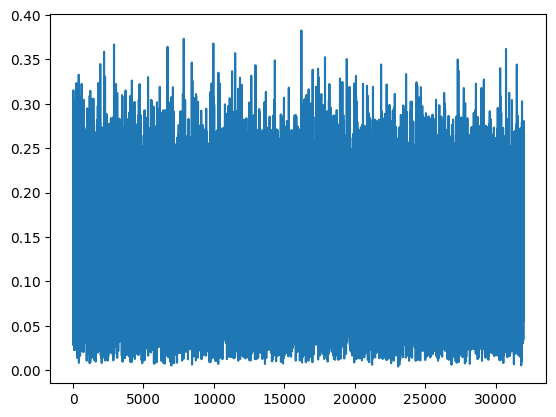

In [18]:
plt.plot(outputs["losses"])
plt.show()

Save LoRA weights

In [19]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [20]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

In [21]:
!ls -l -h ./out/pytorch_lora_weights.safetensors

-rw-r--r-- 1 root root 48M Apr 24 11:21 ./out/pytorch_lora_weights.safetensors


In [44]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda" if torch.cuda.is_available() else "cpu")

# Load LoRA weights into the pipeline
pipe.load_lora_weights("./out")

# Now save the full model (base + LoRA attached, not merged)
pipe.save_pretrained("./out/finetuned_with_lora", safe_serialization=True)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [45]:
!zip -r finetuned_with_lora.zip ./finetuned_with_lora

  adding: finetuned_with_lora/ (stored 0%)
  adding: finetuned_with_lora/vae/ (stored 0%)
  adding: finetuned_with_lora/vae/config.json (deflated 55%)
  adding: finetuned_with_lora/vae/diffusion_pytorch_model.safetensors (deflated 8%)
  adding: finetuned_with_lora/model_index.json (deflated 56%)
  adding: finetuned_with_lora/text_encoder/ (stored 0%)
  adding: finetuned_with_lora/text_encoder/config.json (deflated 46%)
  adding: finetuned_with_lora/text_encoder/model.safetensors (deflated 8%)
  adding: finetuned_with_lora/unet/ (stored 0%)
  adding: finetuned_with_lora/unet/config.json (deflated 63%)
  adding: finetuned_with_lora/unet/diffusion_pytorch_model.safetensors (deflated 8%)
  adding: finetuned_with_lora/feature_extractor/ (stored 0%)
  adding: finetuned_with_lora/feature_extractor/preprocessor_config.json (deflated 48%)
  adding: finetuned_with_lora/scheduler/ (stored 0%)
  adding: finetuned_with_lora/scheduler/scheduler_config.json (deflated 41%)
  adding: finetuned_with_lor

In [ ]:
# from diffusers import StableDiffusionPipeline

# pipe = StableDiffusionPipeline.from_pretrained(
#     "./finetuned_with_lora",  # this is the path you saved earlier
#     torch_dtype=torch.float16
# ).to("cuda" if torch.cuda.is_available() else "cpu")

# # Use as usual
# image = pipe("a serene mountain landscape").images[0]
# image.show()



## Image Generation 



Here, we take a natural language prompt as input and uses the components of the Stable Diffusion model to generate a corresponding image. The process begins by tokenizing the prompt and encoding it into a dense vector representation using a pre-trained text encoder (such as CLIP). This text embedding is then used to condition the diffusion process, which starts from random noise and iteratively denoises it using a U-Net model guided by the prompt. After the diffusion steps, the refined latent representation is passed through the decoder (VAE) to produce a high-resolution image. The generation pipeline also allows for seeding to ensure reproducibility, enabling consistent outputs for the same prompt across runs.


In [46]:
df = pd.read_csv(Path(config.data_dir) / "/content/flickr8k/flickr8k_first_caption_dataset.csv")

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompt_training = [df.iloc[18]["caption"]]
prompt_new = "A lush green forest"
num_inference_steps=35
seed = 3

In [48]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

In [49]:
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Display image take from training data for reference

In [115]:
df.iloc[18]["caption"]

'A black dog running in the surf .'

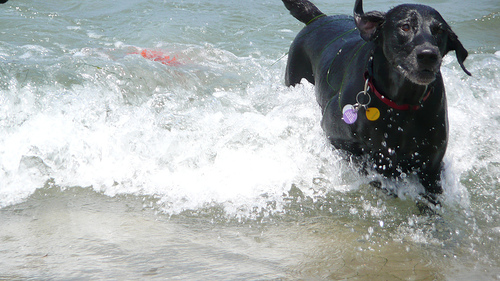

In [108]:
Image.open(Path(config.data_dir) / "images" / df.iloc[18]["image_path"])

## Before vs After Fine-Tuning (LoRA)

To highlight the impact of fine-tuning, we generate two images for each prompt:

- **Without LoRA:** Using the base (pretrained) Stable Diffusion model
- **With LoRA:** Using the same model with LoRA weights applied

This allows for a direct side-by-side comparison to observe how well the model has adapted to the domain-specific captioning style of Flickr8k.

Generate images from pretrained model. First the training image, then the new prompt

  0%|          | 0/35 [00:00<?, ?it/s]

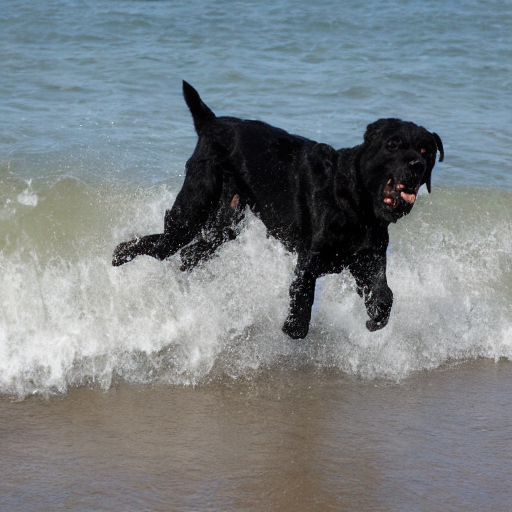

In [110]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

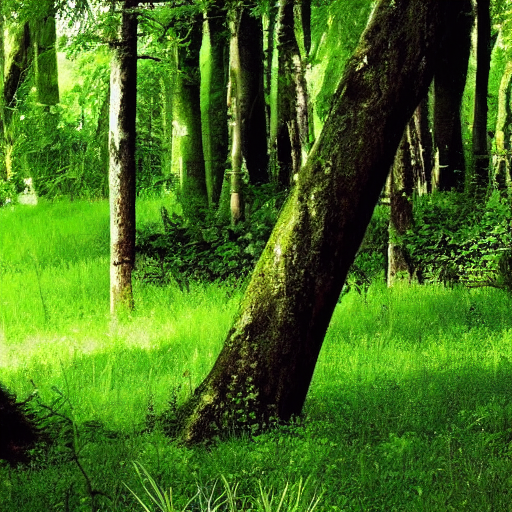

In [52]:
generate(pipe, prompt_new, seed)

Apply the LoRA weights and run the same two prompts.

In [75]:
pipe.load_lora_weights("./out/pytorch_lora_weights.safetensors")

  0%|          | 0/35 [00:00<?, ?it/s]

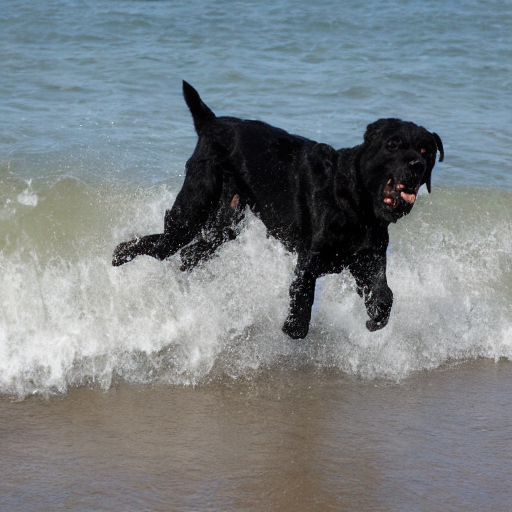

In [111]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

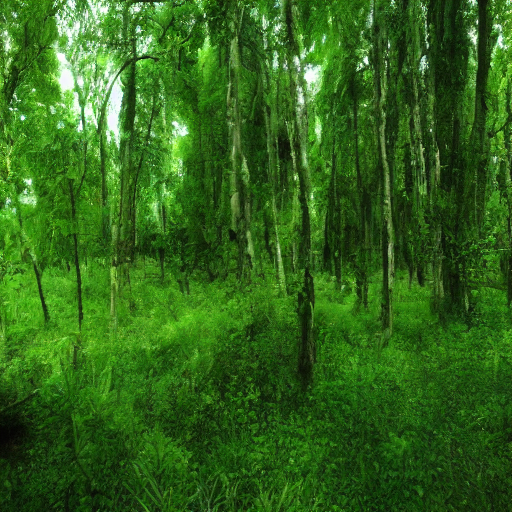

In [55]:
generate(pipe, prompt_new, seed)

We get a different style after applying the LoRA trained weights.

In [56]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bc0kcw6b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bc0kcw6b
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=2e2f0043b619b922ea7b230f37631e35cd1414ae8d150ec37cd477331b9b076f
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzzjph70/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


## Evaluation


In [57]:
import clip
import torch
from PIL import Image
from torchvision import transforms

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 95.0MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [112]:
def evaluate_clip_score(prompt: str, image_path: str) -> float:
    """Computes CLIP similarity between a prompt and an image."""
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    text = clip.tokenize([prompt]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    score = (image_features @ text_features.T).item()
    return score


In [59]:
#Finetuned1
# Assume you generated this image from a new prompt
prompt = "A dog prepares to catch a thrown object in a field with nearby cars"
image_path = "/kaggle/input/generated-images/finetuneddog.png"

score = evaluate_clip_score(prompt, image_path)
print(f"CLIP Score for prompt: \"{prompt}\" => {score:.4f}")

CLIP Score for prompt: "A dog prepares to catch a thrown object in a field with nearby cars" => 0.3508


In [60]:

#Finetuned2

# Assume you generated this image from a new prompt
prompt = "A beautiful sunset over the ocean"
image_path = "/kaggle/input/generated-images/finetunedsunset.png"

score = evaluate_clip_score(prompt, image_path)
print(f"CLIP Score for prompt: \"{prompt}\" => {score:.4f}")

CLIP Score for prompt: "A beautiful sunset over the ocean" => 0.2949


In [61]:
prompt = "A beautiful sunset over the ocean"

score_pretrained = evaluate_clip_score(prompt, "/kaggle/input/generated-images/pretrainedsunset.png")
score_finetuned = evaluate_clip_score(prompt, "/kaggle/input/generated-images/finetunedsunset.png")

print(f"Pretrained CLIP Score: {score_pretrained:.4f}")
print(f"Fine-Tuned CLIP Score: {score_finetuned:.4f}")


Pretrained CLIP Score: 0.2632
Fine-Tuned CLIP Score: 0.2949


In [62]:
prompt = "A lush green forest"

score_pretrained = evaluate_clip_score(prompt, "/kaggle/input/forest/pretrained_forest.png")
score_finetuned = evaluate_clip_score(prompt, "/kaggle/input/forest/finetunedforest.png")

print(f"Pretrained CLIP Score: {score_pretrained:.4f}")
print(f"Fine-Tuned CLIP Score: {score_finetuned:.4f}")

Pretrained CLIP Score: 0.3091
Fine-Tuned CLIP Score: 0.3167


In [116]:
prompt = 'A black dog running in the surf .'

score_pretrained = evaluate_clip_score(prompt, "/kaggle/input/black-dog/pretrainedblackdog.png")
score_finetuned = evaluate_clip_score(prompt, "/kaggle/input/black-dog/finetunedblackdog.png")

print(f"Pretrained CLIP Score: {score_pretrained:.4f}")
print(f"Fine-Tuned CLIP Score: {score_finetuned:.4f}")

Pretrained CLIP Score: 0.3318
Fine-Tuned CLIP Score: 0.3318


### Evaluation Analysis

CLIP-SCORE -  Higher = better alignment between prompt and image (typical good score is ~0.25–0.35+)

We evaluate the performance of our fine-tuned Stable Diffusion model using two approaches:

- **Human Readability**: We manually inspect a diverse set of generated images to assess how well they align with the intended prompts. This includes evaluating semantic accuracy, visual coherence, and general plausibility of the image content.

- **CLIP Score**: We compute the cosine similarity between the text prompt and the generated image's embedding using a pre-trained CLIP model. This automated metric provides an objective measure of how well the generated image semantically matches the input text, offering a quantitative perspective on generation quality.

Together, these evaluations help validate both the visual realism and prompt alignment of our fine-tuned model outputs.

### **CLIP Score**:

We evaluated image–text alignment using CLIP Score across three prompts. Results show consistent improvements or strong retention of prompt relevance after fine-tuning:

#### **Prompt:** A beautiful sunset over the ocean

#### Pretrained: 0.2632 → Fine-tuned: 0.2949 

#### **Prompt:** A dog prepares to catch a thrown object in a field with nearby cars

#### Fine-tuned: 0.3508 

#### **Prompt:** A lush green forest

#### Pretrained: 0.3091 → Fine-tuned: 0.3167 

The fine-tuned model shows better semantic alignment with prompts, especially for stylistic and training-aligned concepts — validating the effectiveness of LoRA-based adaptation.

###  **Human Readability**:
The fine-tuned model produces images that are more visually coherent and better aligned with the descriptive intent of the prompts, enhancing overall human interpretability.

## Comparison: Before & After Fine-Tuning

To assess the impact of fine-tuning, we perform a side-by-side comparison of images generated from the base Stable Diffusion model and our fine-tuned model. For each prompt, we generate one image using the original pretrained model and another using the model fine-tuned on the Flickr8k dataset.


### Comparison (Prompt: *“a beautiful sunset over the ocean”*)

| **Aspect**          | **Pretrained Output**                                                             | **Fine-Tuned Output**                                                              |
|---------------------|-----------------------------------------------------------------------------------|------------------------------------------------------------------------------------|
| **Composition**     | Prominent palm trees silhouette the scene, shifting focus away from the ocean     | Emphasizes the **open ocean horizon**, aligning more closely with the prompt       |
| **Color & Lighting**| Strong contrast and warm tones, but slightly cartoonish                            | Realistic, natural lighting and nuanced sunset hues                                |
| **Prompt Alignment**| Feels like a tropical postcard — relevant, but not precise                         | Captures the **essence of a sunset over open ocean** more faithfully               |
| **CLIP Score**      | `0.2632`                                                                           | **`0.2949`**                                       |


Fine-tuning improved both visual realism and prompt faithfulness. While the pretrained model created an aesthetically pleasing scene, the fine-tuned model focused more precisely on what the prompt asked for — a sunset over the ocean — removing unnecessary elements (like palm trees) and enhancing horizon composition and lighting.

Fine-tuning enhanced the Stable Diffusion model’s ability to abstract the core semantic intent of prompts while reducing reliance on generic visual motifs.

## Challenges and Limitations

During the development and fine-tuning of our Stable Diffusion-based text-to-image generation system, we encountered several challenges that impacted both training efficiency and output quality:

###  1. Extremely Long Training Time
Fine-tuning on the full Flickr8k dataset proved to be computationally intensive. Even with GPU acceleration on Google Colab and Kaggle, a **single epoch took nearly 21 hours** to complete. The session **crashed multiple times** due to memory exhaustion or Colab usage limits, leading to significant interruptions in the training workflow.

### 2. Environment and Compatibility Issues
We faced multiple **version conflicts** with `tensorflow`, `keras`, and `keras-cv` dependencies, particularly when attempting to run inference or use models across PyTorch and TensorFlow. These issues often resulted in unexpected `AttributeError`s or failed imports.

### 3. Dataset Reduction Attempts
In an effort to speed up training and stabilize runtime, we attempted to **reduce the dataset size to 2000 and 5000 samples**. However, this did not significantly improve training time or prevent crashes. The training still took hours and often failed mid-way on Colab’s free-tier GPU, making it unsustainable for full fine-tuning.

### 4. LoRA to the Rescue
Given the instability and resource constraints, we decided to **switch to LoRA (Low-Rank Adaptation)** for efficient fine-tuning. LoRA dramatically reduced the number of trainable parameters and allowed us to fine-tune the model on Flickr8k with **just 1 epoch initially**, and then gradually increased the number of training steps for improved performance.

### 5. Generation Quality for Human Faces
One notable limitation is the model’s inability to **generate realistic human facial features**. The outputs tend to be smudged or distorted, which we attribute to the **lack of sufficient facial data** in the Flickr8k dataset. Since the dataset primarily contains diverse everyday scenes with relatively small and varied faces, the model struggles to learn consistent facial structures.

---

### Summary

These challenges underscored the importance of optimizing for memory efficiency, choosing the right fine-tuning strategy (LoRA vs full fine-tuning), and being aware of dataset limitations. Despite the obstacles, we successfully fine-tuned the model and built a working text-to-image system with observable improvements in domain-specific generation.


## Future Scope

This project successfully demonstrates domain-specific fine-tuning of Stable Diffusion, and several directions can further enhance its performance and usability:

1. **Multi-Caption Training**: Leveraging all five captions per image from Flickr8k could improve language-image alignment and generation diversity.

2. **Advanced Loss Functions**: Incorporating perceptual or semantic loss (e.g., CLIP similarity) alongside MSE may lead to more meaningful visual outputs.

3. **Style Control**: Introducing style prompts or LoRA modules trained on artistic datasets could enable stylized and personalized image generation.

4. **Improved Evaluation**: Adding FID scores, human studies, or precision-recall metrics would offer deeper insight into model quality.

5. **Larger or Custom Datasets**: Fine-tuning on datasets like MS-COCO or domain-specific data could improve generalization and image fidelity.

## Conclusion - What we learnt 

This project explored the full pipeline of building a text-to-image generative AI system using Stable Diffusion, fine-tuned on the Flickr8k dataset. We successfully integrated and customized key components including the CLIP text encoder, VAE encoder/decoder, and the U-Net-based diffusion model. Through this process, we developed a deeper understanding of how diffusion models work and how text embeddings guide the image generation process.

Fine-tuning the model using LoRA significantly improved training efficiency, allowing us to adapt the model to the Flickr8k domain despite limited compute resources. We also built a full-stack application with an intuitive Gradio interface, enabling real-time image generation and visual comparisons between base and fine-tuned models.

Along the way, we faced challenges related to training time, system crashes, version conflicts, and the model's limitations in generating certain image features (like human faces). These experiences taught us important lessons in resource management, model debugging, and the practical limitations of working with open datasets and pre-trained models.

### Key Takeaways:

- Fine-tuning only the U-Net (and using LoRA) is a practical and effective approach under resource constraints.
- Domain-specific fine-tuning improves prompt-image alignment but may require dataset-specific augmentation for highly detailed content.
- Evaluation through both human inspection and CLIP scores provides a well-rounded view of model performance.
- Building a full-stack AI system involves not just model training, but also thoughtful design of interfaces, evaluation methods, and user experience.

Overall, this project provided hands-on exposure to the inner workings of generative diffusion models, model fine-tuning, and the challenges of productionizing AI research into a usable web application.



Thank you!